In [23]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
import csv
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression



In [24]:
# Feature definitions
features = ["Episode_Length_minutes", "Number_of_Ads", "Host_Popularity_percentage",
            "Guest_Popularity_percentage", "Episode_Sentiment", "Publication_Day",
            "Publication_Time", "Genre", "Podcast_Name"]

features_to_encode = ["Episode_Sentiment", "Publication_Day", "Publication_Time", "Genre", "Podcast_Name"]

# Label encoders
encoders = {feature: LabelEncoder() for feature in features_to_encode}


In [13]:
'''
lr = 0.375
n_estimators = 1200
max_bin = 1024

common_params = {
    "objective": "reg:squarederror",
    "n_estimators": n_estimators,
    "max_depth": 6,
    "learning_rate": lr,
    "max_bin": max_bin,
    "verbosity": 0
}

models = []
for _ in range(10):
    model = xgb.XGBRegressor(**common_params)
    model.fit(x, y, eval_set=[(x, y)], verbose=True)
    models.append(model)

model1, model2, model3, model4, model5, model6, model7, model8, model9, model10 = models
'''


'\nlr = 0.375\nn_estimators = 1200\nmax_bin = 1024\n\ncommon_params = {\n    "objective": "reg:squarederror",\n    "n_estimators": n_estimators,\n    "max_depth": 6,\n    "learning_rate": lr,\n    "max_bin": max_bin,\n    "verbosity": 0\n}\n\nmodels = []\nfor _ in range(10):\n    model = xgb.XGBRegressor(**common_params)\n    model.fit(x, y, eval_set=[(x, y)], verbose=True)\n    models.append(model)\n\nmodel1, model2, model3, model4, model5, model6, model7, model8, model9, model10 = models\n'

In [25]:
def preprocess(df, is_train=True):
    # df["Episode_Title"] = df["Episode_Title"].str[8:]

    # Impute missing values
    for col in ["Episode_Length_minutes", "Guest_Popularity_percentage", "Number_of_Ads"]:
        df[[col]] = SimpleImputer(strategy="median").fit_transform(df[[col]])

    # Weekend flag

    # Label encode categorical variables
    for feature in features_to_encode:
        if is_train:
            df[feature] = encoders[feature].fit_transform(df[feature])
        else:
            df[feature] = encoders[feature].transform(df[feature])

    # Feature engineering
    # df["Ads_Per_Minute"] = df["Number_of_Ads"] / df["Episode_Length_minutes"]
    # df["People_Popularity"] = df["Host_Popularity_percentage"] + df["Guest_Popularity_percentage"]
    # df["Linear"] = df["Episode_Length_minutes"] * 0.72

    return df


In [26]:
# engineered = ["Ads_Per_Minute", "People_Popularity", "Linear"]
def get_train_data(file):
    df = pd.read_csv(file)
    y = df[["Listening_Time_minutes"]].to_numpy().astype(np.float32)
    df = preprocess(df, is_train=True)
    x = df[features].to_numpy().astype(np.float32)
    return x, y

def get_test_data(file):
    df = pd.read_csv(file)
    df = preprocess(df, is_train=False)
    x = df[features].to_numpy().astype(np.float32)
    return x



In [27]:
x, y = get_train_data("train.csv")
X_test = get_test_data("test.csv")


In [28]:
common_params = {
    "objective": "regression",
    "n_estimators": 1000,
    "learning_rate": 0.03,
    "max_bin": 1024,
    "num_leaves": 1024,
    "max_depth": -1,
    "subsample": 0.7,
    "colsample_bytree": 0.7,
    "random_state": 42
}


In [29]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
models = []

for train_index, val_index in kf.split(x):
    x_train, x_val = x[train_index], x[val_index]
    y_train, y_val = y[train_index], y[val_index]
    
    model = lgb.LGBMRegressor(**common_params)
    model.fit(x_train, y_train, eval_set=[(x_val, y_val)], eval_metric="rmse", callbacks=[lgb.log_evaluation(100)])
    models.append(model)


c:\repos\class\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010428 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3149
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 9
[LightGBM] [Info] Start training from score 45.447808


c:\repos\class\.venv\Lib\site-packages\lightgbm\basic.py:374: UserWarning: Converting column-vector to 1d array
  _log_warning("Converting column-vector to 1d array")


[100]	valid_0's rmse: 13.3247	valid_0's l2: 177.546
[200]	valid_0's rmse: 12.8647	valid_0's l2: 165.5
[300]	valid_0's rmse: 12.8105	valid_0's l2: 164.109
[400]	valid_0's rmse: 12.7864	valid_0's l2: 163.492
[500]	valid_0's rmse: 12.7669	valid_0's l2: 162.993
[600]	valid_0's rmse: 12.7527	valid_0's l2: 162.63
[700]	valid_0's rmse: 12.7409	valid_0's l2: 162.329
[800]	valid_0's rmse: 12.7298	valid_0's l2: 162.048
[900]	valid_0's rmse: 12.7225	valid_0's l2: 161.863
[1000]	valid_0's rmse: 12.7163	valid_0's l2: 161.705


c:\repos\class\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011045 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3149
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 9
[LightGBM] [Info] Start training from score 45.421359


c:\repos\class\.venv\Lib\site-packages\lightgbm\basic.py:374: UserWarning: Converting column-vector to 1d array
  _log_warning("Converting column-vector to 1d array")


[100]	valid_0's rmse: 13.3749	valid_0's l2: 178.889
[200]	valid_0's rmse: 12.9166	valid_0's l2: 166.839
[300]	valid_0's rmse: 12.8617	valid_0's l2: 165.422
[400]	valid_0's rmse: 12.8357	valid_0's l2: 164.754
[500]	valid_0's rmse: 12.8172	valid_0's l2: 164.281
[600]	valid_0's rmse: 12.8011	valid_0's l2: 163.869
[700]	valid_0's rmse: 12.7889	valid_0's l2: 163.555
[800]	valid_0's rmse: 12.776	valid_0's l2: 163.226
[900]	valid_0's rmse: 12.7699	valid_0's l2: 163.071
[1000]	valid_0's rmse: 12.7631	valid_0's l2: 162.897


c:\repos\class\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009957 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3150
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 9
[LightGBM] [Info] Start training from score 45.439263


c:\repos\class\.venv\Lib\site-packages\lightgbm\basic.py:374: UserWarning: Converting column-vector to 1d array
  _log_warning("Converting column-vector to 1d array")


[100]	valid_0's rmse: 13.3635	valid_0's l2: 178.583
[200]	valid_0's rmse: 12.903	valid_0's l2: 166.489
[300]	valid_0's rmse: 12.8483	valid_0's l2: 165.079
[400]	valid_0's rmse: 12.8219	valid_0's l2: 164.401
[500]	valid_0's rmse: 12.8033	valid_0's l2: 163.925
[600]	valid_0's rmse: 12.7896	valid_0's l2: 163.575
[700]	valid_0's rmse: 12.7777	valid_0's l2: 163.269
[800]	valid_0's rmse: 12.7659	valid_0's l2: 162.968
[900]	valid_0's rmse: 12.7564	valid_0's l2: 162.726
[1000]	valid_0's rmse: 12.7507	valid_0's l2: 162.579


c:\repos\class\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010819 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3149
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 9
[LightGBM] [Info] Start training from score 45.453215


c:\repos\class\.venv\Lib\site-packages\lightgbm\basic.py:374: UserWarning: Converting column-vector to 1d array
  _log_warning("Converting column-vector to 1d array")


[100]	valid_0's rmse: 13.3747	valid_0's l2: 178.884
[200]	valid_0's rmse: 12.9019	valid_0's l2: 166.46
[300]	valid_0's rmse: 12.8474	valid_0's l2: 165.055
[400]	valid_0's rmse: 12.8199	valid_0's l2: 164.349
[500]	valid_0's rmse: 12.8026	valid_0's l2: 163.906
[600]	valid_0's rmse: 12.7886	valid_0's l2: 163.549
[700]	valid_0's rmse: 12.7761	valid_0's l2: 163.228
[800]	valid_0's rmse: 12.7662	valid_0's l2: 162.976
[900]	valid_0's rmse: 12.7561	valid_0's l2: 162.717
[1000]	valid_0's rmse: 12.7478	valid_0's l2: 162.506


c:\repos\class\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006644 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3149
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 9
[LightGBM] [Info] Start training from score 45.425388


c:\repos\class\.venv\Lib\site-packages\lightgbm\basic.py:374: UserWarning: Converting column-vector to 1d array
  _log_warning("Converting column-vector to 1d array")


[100]	valid_0's rmse: 13.3062	valid_0's l2: 177.055
[200]	valid_0's rmse: 12.8569	valid_0's l2: 165.3
[300]	valid_0's rmse: 12.803	valid_0's l2: 163.916
[400]	valid_0's rmse: 12.7755	valid_0's l2: 163.214
[500]	valid_0's rmse: 12.7569	valid_0's l2: 162.739
[600]	valid_0's rmse: 12.742	valid_0's l2: 162.359
[700]	valid_0's rmse: 12.7288	valid_0's l2: 162.023
[800]	valid_0's rmse: 12.7182	valid_0's l2: 161.751
[900]	valid_0's rmse: 12.7088	valid_0's l2: 161.513
[1000]	valid_0's rmse: 12.6996	valid_0's l2: 161.28


In [30]:
preds = sum(model.predict(X_test) for model in models) / len(models)

with open("submission_lgbm.csv", "w", newline='') as f:
    writer = csv.writer(f)
    writer.writerow(["id", "prediction"])
    for i, pred in enumerate(preds, start=750000):
        writer.writerow([i, pred])


c:\repos\class\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\repos\class\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\repos\class\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\repos\class\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\repos\class\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [21]:
features_to_plot = ["Episode_Length_minutes", "Host_Popularity_percentage", 
                    "Guest_Popularity_percentage", "Listening_Time_minutes", "Number_of_Ads"]
df = pd.read_csv("train.csv")

plt.figure(figsize=(15, 10))
for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[feature], kde=True)
    plt.title(f"Distribution of {feature}")
plt.tight_layout()
plt.show()

TypeError: 'module' object is not callable

In [ ]:
correlation_matrix = df[features_to_plot].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap")
plt.show()

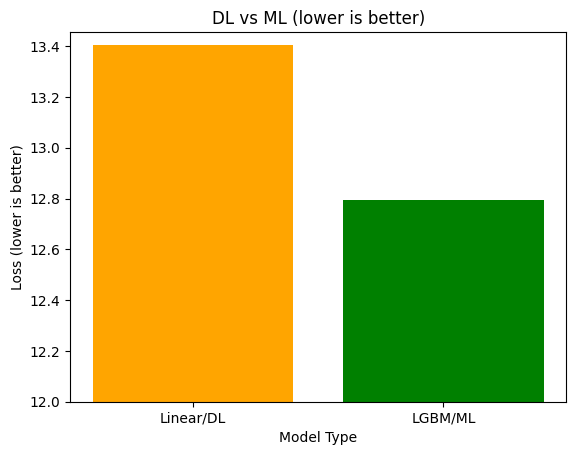

In [36]:
categories = ["Linear/DL", "LGBM/ML"]
values = [13.40522, 12.79389]

plt.bar(categories, values, color=["orange", "green"])

plt.ylim(12, max(values) + 0.05)

plt.xlabel("Model Type")
plt.ylabel("Loss (lower is better)")
plt.title("DL vs ML (lower is better)")

plt.show()

Slope: 0.7152365802402607


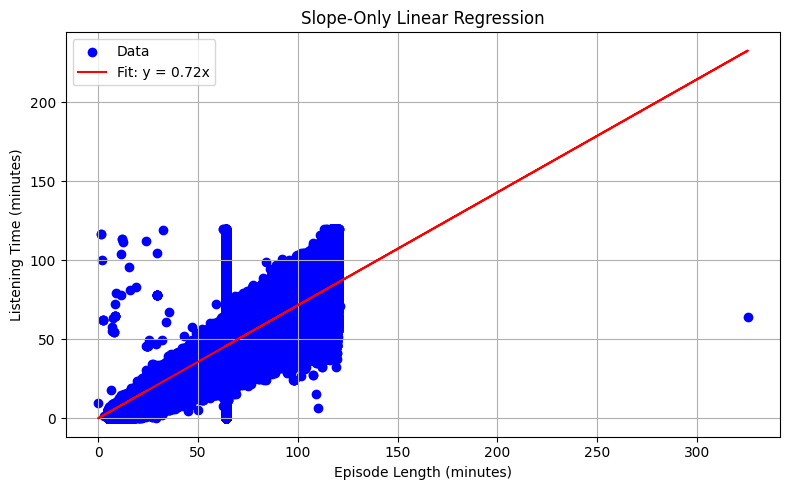

In [ ]:

# Load the CSV
df = pd.read_csv("train.csv")

# Extract variables
df["Episode_Length_minutes"] = SimpleImputer(strategy="median").fit_transform(df[["Episode_Length_minutes"]])
X = df[['Episode_Length_minutes']]  # needs to be 2D
y = df['Listening_Time_minutes']

# Fit linear regression through the origin (no intercept)
model = LinearRegression(fit_intercept=False)
model.fit(X, y)

# Get slope
slope = model.coef_[0]
print(f"Slope: {slope}")

# Predict values
y_pred = model.predict(X)

# Plot
plt.figure(figsize=(8, 5))
plt.scatter(X, y, color='blue', label='Data')
plt.plot(X, y_pred, color='red', label=f'Fit: y = {slope:.2f}x')
plt.xlabel("Episode Length (minutes)")
plt.ylabel("Listening Time (minutes)")
plt.title("Slope-Only Linear Regression")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


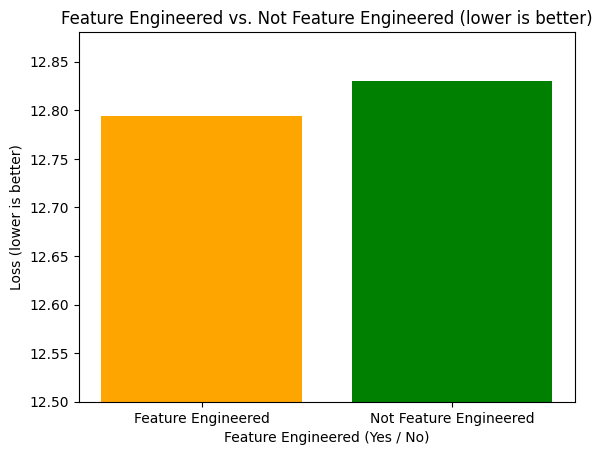

In [37]:
categories = ["Feature Engineered", "Not Feature Engineered"]
values = [12.79389, 12.83051]

plt.bar(categories, values, color=["orange", "green"])

plt.ylim(12.5, max(values) + 0.05)

plt.xlabel("Feature Engineered (Yes / No)")
plt.ylabel("Loss (lower is better)")
plt.title("Feature Engineered vs. Not Feature Engineered (lower is better)")

plt.show()